# Planes and projections

## 3 points define a 2D plane

Suppose we have 3 weight vectors $w_1, w_2, w_3$. 
We set 
$$u=(w_2-w_1) \text{, and } v=(w_3-w_1)- \frac{\langle w_3-w_1, w_2-w_1\rangle}{||w_2-w_1||^2}(w_2-w_1)$$

Then the normalized vectors $\hat{u}=u/||u||, \hat{v}=v/||v||$ form an orthonormal basis in the plane containing $w_1, w_2, w_3$. To visualize the loss in this plane, we define a Cartesian grid in the basis $\hat{u}, \hat{v}$ and evaluate the networks corresponding to each of the points in the grid. 
A point $p$ with coordinates $(x,y)$ in the plane would then be given by $p=w_1+x\hat{u}+y\hat{v}$.

For more info see: Garipov, T., Izmailov, P., Podoprikhin, D., Vetrov, D.P. and Wilson, A.G., 2018. Loss surfaces, mode connectivity, and fast ensembling of dnns. In Advances in Neural Information Processing Systems (pp. 8789-8798).


## Projections onto the plane

Vectors $\hat{u}$ and $\hat{v}$ form an orthonormal basis in the plane containing $w_1, w_2, w_3$. 
This plane (shifted by $w_1$) is the column space of the matrix $A = [\hat{u}, \hat{v}]$.
Suppose we want to project some point $b$ onto that plane, i.e., find the closest point $p^*$ on that plane.
We know that 

$$p^* = w_1 + x^*\hat{u}+ y^*\hat{v} = w_1 + Ac^*$$

We know that $b-p^*$ is orthogonal to the plane and thus, 

$$A^T(b-w_1-Ac^*) = 0$$

or equivalently

$$A^TAc^* = A^T(b-w_1)$$

Finally, 

$$c^* = (A^TA)^{-1}A^T(b-w_1)$$

For more info see: https://ocw.mit.edu/courses/mathematics/18-06sc-linear-algebra-fall-2011/least-squares-determinants-and-eigenvalues/projections-onto-subspaces/MIT18_06SCF11_Ses2.2sum.pdf


## Code

### Handling weight & bias dictionaries and vectors

In [1]:
import itertools
flatten = itertools.chain.from_iterable

def dictovec(a):   
    # receives a dictionary and converts its values into a vector
    # val.flatten() flattens the matrix of weights of each layer
    # flatten from itertools joins the list of lists 
    # a: weight dictionary
    
    avec = np.array(list(flatten([val.flatten() for val in a.values()])))
    return avec

def shapeslengths(a):
    # receives a dictionary and extracts the shape and the total number of weights in each layer
    # a: weight dictionary
    
    return [val.shape for val in a.values()], [len(val.flatten()) for val in a.values()]

def vectodict(avec, keys, shapes, lengths):
    # receives a weight vector, the keys and the shapes for each layer
    # and outputs a weight dictionary
    # avec: vector of all the NN weights
    # keys: keys needed for dictionary - as obtained from .keys()
    # shapes: shape for each layer weight matrix
    # lengths: number of weights in each layer
    
    l = [] # creates a list of weight matrices
    k = 0
    for i, s in enumerate(shapes):
        l.append(avec[k : k + lengths[i]].reshape(s))
        k += lengths[i]
    a = dict(zip(keys, l))
    return a

def abtovec(a, b):
    # receives weight and bias dictionaries and converts them into a weight+bias vector
    
    return np.concatenate((dictovec(a), dictovec(b)))

def cvectodict(cvec, akeys, bkeys, sa, la, sb, lb):
    # receives a weight & bias vector as well as keys and shapes of weight and bias dictionaries
    # outputs weight & bias dictionaries
    # keys as obtained from .keys()
    
    avec = cvec[:sum(la)]
    bvec = cvec[sum(la):]
    
    return vectodict(avec, list(akeys), sa, la), vectodict(bvec, list(bkeys), sb, lb)

### Basis of a plane

In [2]:
def abcvectobasis(avec, bvec, cvec, wkeys, bkeys, sw, lw, sb, lb):

    # receives 3 weight & bias vectors as well as keys and shapes of weight and bias dictionaries
    # outputs basis vectors (weight+bias dictionaries)

    uvec = bvec - avec
    u_sq = sum([x**2 for x in uvec])
    u_norm = np.sqrt(u_sq)
    u_hat_vec = uvec / u_norm
    u_hat_w, u_hat_b = cvectodict(u_hat_vec, wkeys, bkeys, sw, lw, sb, lb)

    cmavec = cvec - avec

    inner = sum([x * y for x, y in zip(uvec, cmavec)])

    vvec = cmavec - inner / u_sq * uvec
    v_sq = sum([x**2 for x in vvec])
    v_norm = np.sqrt(v_sq)

    v_hat_vec = vvec / v_norm
    v_hat_w, v_hat_b = cvectodict(v_hat_vec, wkeys, bkeys, sw, lw, sb, lb)
    
    return u_hat_vec, v_hat_vec, u_norm, v_norm, inner

### Projecting onto a plane

In [3]:
def projtoplane(wvec, wb1vec, u_hat_vec, v_hat_vec):
    # receives a weight & bias vector and the plane shift and basis vectors
    # outputs the x, y values corresponding to the projection of the vector onto the plane
    
    basis = np.concatenate((u_hat_vec.reshape(-1,1), v_hat_vec.reshape(-1,1)), axis = 1)
    ata = np.linalg.inv(np.matmul(basis.transpose(), basis))   
    prx, pry = np.matmul(ata, np.matmul(basis.transpose(), wvec - wb1vec))
    
    return prx, pry

### Example

We run a simple NN 3 times with different initializations for obtaining 3 different optima. 

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# data
n = 150
X_data = np.linspace(0, 10, n)
X_data = X_data.reshape((n, 1))
Y_data = np.sin(X_data) + 2* np.sin(2 * X_data) + 0.3 * (X_data - 5)**2 
data = np.concatenate((X_data, Y_data), axis=1)
np.random.shuffle(data)
data_tr, data_val= np.split(data, [int(0.8 * n)], axis = 0) # validation data not used here
n_tr, n_val = data_tr.shape[0], data_val.shape[0] 

# function extracting the i-th batch of the epoch
def next_batch(data_tr, i, batch_size):
    return data_tr[i * batch_size : (i + 1) * batch_size - 1, :] 

# various parameters
learning_rate = 0.02
num_epochs = 4000
batch_size = n_tr // 1
itpep = n_tr // batch_size
wd_par = 0.0
# network parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 1 
num_output = 1 
# tf graph input
X = tf.placeholder(tf.float32, shape = [None, 1])
Y = tf.placeholder(tf.float32, shape = [None, 1])
# weight & bias dictionaries
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_output]))
}
# model function
def neural_net(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer

fp = neural_net(X)
error = tf.reduce_sum(tf.pow(fp - Y, 2)) / tf.cast(tf.size(Y), float)
loss = tf.reduce_sum(tf.pow(fp - Y, 2)) / tf.cast(tf.size(Y), float) \
                + wd_par * tf.reduce_sum([tf.reduce_sum(tf.pow(weights[i], 2)) for i in weights])
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

opt_weights = []
opt_biases = []
init_weights = []
init_biases = []

sess = tf.Session()

num = 3
for c in range(num):
    sess.run(init)
    init_weights.append(sess.run(weights))
    init_biases.append(sess.run(biases))
    i = 0
    for iteration in range(num_epochs * itpep):          
        data_batch = next_batch(data_tr, i, batch_size)
        sess.run(train_op, feed_dict={X: data_batch[:, [0]], Y: data_batch[:, [1]]})           
        if (iteration + 1) % itpep == 0:
            i = 0
        else:
            i += 1                
    print('Optimization %.1d out of %.1d finished!' %(c+1, num))
    opt_weights.append(sess.run(weights))
    opt_biases.append(sess.run(biases))

W0911 19:01:24.862440  9592 deprecation.py:323] From C:\Users\afpsa\Anaconda3\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Optimization 1 out of 3 finished!
Optimization 2 out of 3 finished!
Optimization 3 out of 3 finished!


We create a plane defined by the 3 optima and plot the training loss on it. 
We project also the initial weights onto it. 

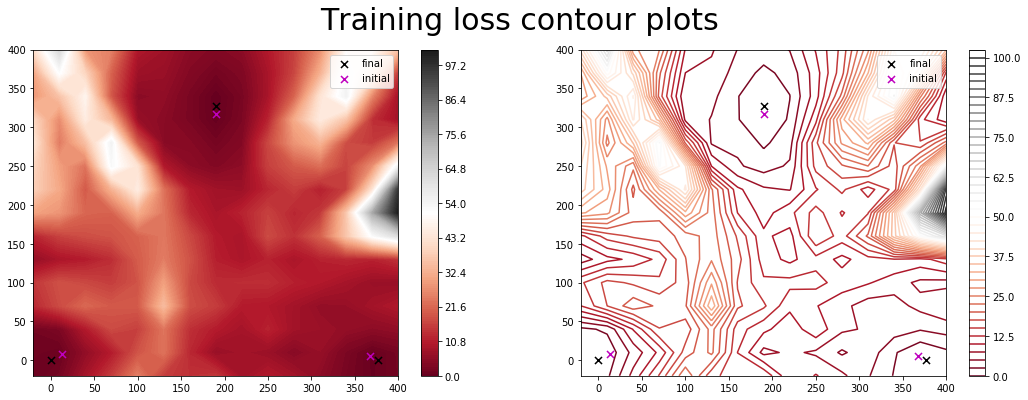

In [5]:
sw, lw = shapeslengths(opt_weights[0])
sb, lb = shapeslengths(opt_biases[0])
wkeys = opt_weights[0].keys()
bkeys = opt_biases[0].keys()

w1vec = abtovec(opt_weights[0], opt_biases[0])
w2vec = abtovec(opt_weights[1], opt_biases[1])
w3vec = abtovec(opt_weights[2], opt_biases[2])

u_hat_vec, v_hat_vec, u_norm, v_norm, inner = \
abcvectobasis(w1vec, w2vec, w3vec, wkeys, bkeys, sw, lw, sb, lb)

pars = np.linspace(-20, 400, 15)
error_mat = []
for par_1 in pars:
    error_v = []
    for par_2 in pars:        
        wvec_new = w1vec + par_1 * u_hat_vec + par_2 * v_hat_vec
        weights, biases = cvectodict(wvec_new, wkeys, bkeys, sw, lw, sb, lb)       
        fp = neural_net(X)
        error = tf.reduce_sum(tf.pow(fp - Y, 2)) / tf.cast(tf.size(Y), float)      
        error_v.append(sess.run(error, feed_dict = {X: data_tr[:, [0]], Y: data_tr[:, [1]]}))
    error_mat.append(error_v) 

basis = np.concatenate((u_hat_vec.reshape(-1,1), v_hat_vec.reshape(-1,1)), axis = 1)
ata = np.linalg.inv(np.matmul(basis.transpose(), basis))

init_proj_x = []
init_proj_y = []

for c in range(num):
    prx, pry = projtoplane(abtovec(init_weights[c], init_biases[c]), w1vec, u_hat_vec, v_hat_vec)
    init_proj_x.append(prx)
    init_proj_y.append(pry)    

xx, yy = np.meshgrid(pars, pars)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Training loss contour plots', fontsize = 30)

im1 = ax1.contourf(xx, yy, np.array(error_mat).transpose(), 200, origin='lower', cmap='RdGy')
fig.colorbar(im1, ax=ax1)
ax1.scatter([0, u_norm, inner / u_norm], [0, 0, v_norm], marker = 'x', color = 'k', s = 50, label = 'final')
ax1.scatter(init_proj_x, init_proj_y, marker = 'x', color = 'm', s = 50, label = 'initial')
ax1.legend();

im2 = ax2.contour(xx, yy, np.array(error_mat).transpose(), 40, origin='lower', cmap='RdGy')
fig.colorbar(im2, ax=ax2)
ax2.scatter([0, u_norm, inner / u_norm], [0, 0, v_norm], color = 'k', marker = 'x', s = 50, label = 'final')
ax2.scatter(init_proj_x, init_proj_y, marker = 'x', color = 'm', s = 50, label = 'initial')
ax2.legend();

There is a high-loss region between the weights. 
This means that the optima belong to different basins and the predictions will most likely be diverse. 
See next plot for line interpolation between the weights. 

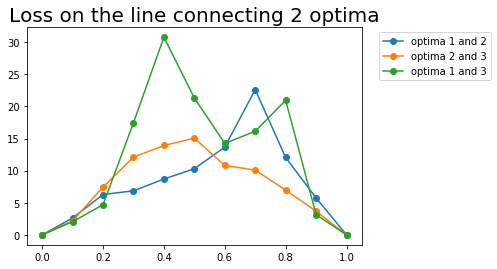

In [6]:
combs = [[0, 1], [1, 2], [0, 2]]
pars = np.linspace(0, 1, 11)

plt.title('Loss on the line connecting 2 optima', fontsize = 20)
for c in range(3):
    error_line = []
    w1vec = abtovec(opt_weights[combs[c][0]], opt_biases[combs[c][0]])
    w2vec = abtovec(opt_weights[combs[c][1]], opt_biases[combs[c][1]])
    for par in pars:
        wvec_new = par * w1vec + (1 - par) * w2vec
        weights, biases = cvectodict(wvec_new, wkeys, bkeys, sw, lw, sb, lb)

        fp = neural_net(X)
        error = tf.reduce_sum(tf.pow(fp - Y, 2)) / tf.cast(tf.size(Y), float) 

        error_line.append(sess.run(error, feed_dict = {X: data_tr[:, [0]], Y: data_tr[:, [1]]}))

    plt.plot(pars, error_line, '-o', label = 'optima %.1d and %.1d' %(combs[c][0]+1, combs[c][1]+1))

plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

Here are the corresponding predictions.

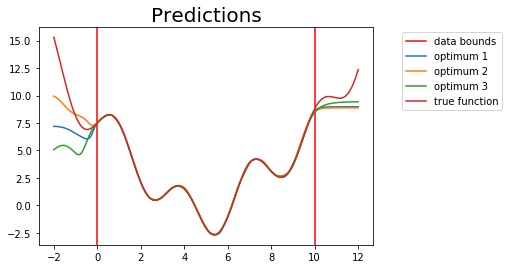

In [7]:
n_eval = 300
X_data = np.linspace(-2, 12, n_eval)
X_data = X_data.reshape((n_eval, 1))
Y_data = np.sin(X_data) + 2* np.sin(2 * X_data) + 0.3 * (X_data - 5)**2 

data_eval = np.concatenate((X_data, Y_data), axis=1)

plt.title('Predictions', fontsize = 20)
plt.axvline(x = 0, label = 'data bounds', color = 'r')
plt.axvline(x = 10, color = 'r')
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    plt.plot(data_eval[:, [0]], sess.run(fp, feed_dict = {X: data_eval[:, [0]]}), label = 'optimum %.1d' %(c+1))
    
plt.plot(data_eval[:, [0]], data_eval[:, [1]], label = 'true function')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()

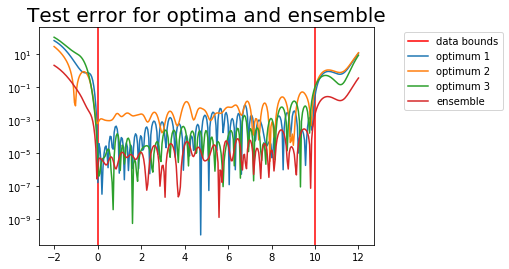

In [8]:
plt.title('Test error for optima and ensemble', fontsize = 20)
plt.yscale('log')
plt.axvline(x = 0, label = 'data bounds', color = 'r')
plt.axvline(x = 10, color = 'r')
ensemble = np.zeros(data_eval[:, [0]].shape)
for c in range(len(opt_weights)):
    weights = opt_weights[c]
    biases = opt_biases[c]
    fp = neural_net(X)
    ensemble += sess.run(fp, feed_dict = {X: data_eval[:, [0]]}) / num
    temp_error = sess.run(tf.pow(fp - Y, 2), feed_dict = {X: data_eval[:, [0]], Y: data_eval[:, [1]]})
    plt.plot(data_eval[:, [0]], temp_error, label = 'optimum %.1d' %(c+1))

ens_error = tf.pow(ensemble-Y, 2)
ens_error = sess.run(ens_error, feed_dict = {Y: data_eval[:, [1]]}) / n_val
plt.plot(data_eval[:, [0]], ens_error, label = 'ensemble')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.show()